In [1]:
import time

from osm_runner import Runner  # pip install osm-runner
import pandas as pd

from arcgis.features import FeatureLayer, GeoAccessor, GeoSeriesAccessor
from arcgis.geoenrichment import enrich
from arcgis import dissolve_boundaries
from arcgis.geometry import project
from arcgis.gis import GIS
from arcgis.features import FeatureLayer, GeoAccessor, GeoSeriesAccessor
from arcgis.geoenrichment import enrich
from arcgis import dissolve_boundaries
from arcgis.geometry import project
from arcgis.gis import GIS
import geopy
from geopy import distance

In [2]:
def str_to_cord(x):
    lat,long = float(x.split(",")[0]),float(x.split(",")[1])
    return lat,long

In [3]:
import requests
import json
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="DE"][admin_level=2];
(node["amenity"="parking_entrance"](area);
 way["amenity"="parking_entrance"](area);
 rel["amenity"="parking_entrance"](area);
);
out center;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data_parking_entrance = response.json()

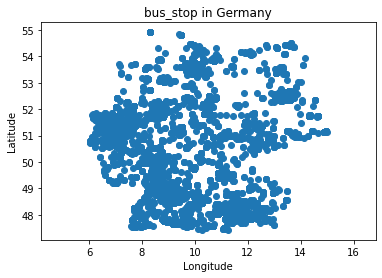

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# Collect coords into list
coords = []
for element in data_parking_entrance['elements']:
    if element['type'] == 'node':
        lon = element['lon']
        lat = element['lat']
        coords.append((lon, lat))
    elif 'center' in element:
        lon = element['center']['lon']
        lat = element['center']['lat']
        coords.append((lon, lat))
# Convert coordinates into numpy array
X = np.array(coords)
plt.plot(X[:, 0], X[:, 1], 'o')
plt.title('bus_stop in Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [5]:
import pandas as pd
df = pd.DataFrame()

In [6]:
df["lat"] = X[:, 1]
df["long"] =X[:, 0]
df["dummy"] = df.lat.apply(lambda x: str(round(x,5)))
df["dummy1"] = df.long.apply(lambda x: "," +str(round(x,5)))
df["dummy2"] = df.dummy+df.dummy1
df["cord"] = df.dummy2.apply(lambda x: str_to_cord(x))
df.drop(["dummy","dummy1","dummy2"],axis =1,inplace=True)

In [7]:
df.head()

,lat,long,cord
0,48.134813,11.389112,"(48.13481, 11.38911)"
1,48.267816,11.677585,"(48.26782, 11.67758)"
2,49.550292,8.673161,"(49.55029, 8.67316)"
3,48.776783,9.178668,"(48.77678, 9.17867)"
4,48.992590,8.401958,"(48.99259, 8.40196)"


In [8]:
dn =pd.read_pickle("stats.pickle")
#dn= dn[["city","latitude","longitude","park_id","postal_code"]]
dn["dummy"] = dn.latitude.apply(lambda x: str(round(x,5)))
dn["dummy1"] = dn.longitude.apply(lambda x: "," +str(round(x,5)))
dn["dummy2"] = dn.dummy+dn.dummy1
dn["cord"] = dn.dummy2.apply(lambda x: str_to_cord(x))
dn.drop(["dummy","dummy1","dummy2"],axis =1,inplace=True)

In [9]:
def  filter_lat_long(cord,th=0.1):
    la1,ln1 = cord
    dk = df.copy()
    return(
    dk
        [dk["lat"]<=la1+th]
        [dk["lat"]>=la1-th]
        [dk["long"]<=ln1+th]
        [dk["long"]>=ln1-th])

In [10]:
filter_lat_long(dn.cord.iloc[0],th=0.2)

<ipython-input-9-18750887360f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dk


,lat,long,cord
987,48.058815,12.233341,"(48.05881, 12.23334)"
988,48.058799,12.233286,"(48.0588, 12.23329)"
3075,47.861624,12.356305,"(47.86162, 12.35631)"
3081,47.862403,12.356462,"(47.8624, 12.35646)"
3769,47.948518,12.191130,"(47.94852, 12.19113)"
5809,47.903356,12.301282,"(47.90336, 12.30128)"
6828,48.063148,12.227937,"(48.06315, 12.22794)"
8760,48.000053,12.406741,"(48.00005, 12.40674)"
12009,47.678082,12.471047,"(47.67808, 12.47105)"
14466,48.000196,12.406828,"(48.0002, 12.40683)"


In [11]:
def nearest(c,th=0.1):
    dk = filter_lat_long(cord = c,th=th)
    if(len(dk)>0):
        dk["distance"] = dk.cord.apply(lambda x: distance.distance(c,x))
        dk = dk.sort_values("distance",ascending = True)
        v  = dk.distance.iloc[0].km
    else:
        v = 1000
    return v

In [12]:
nearest(dn.cord.iloc[0],th=0.2)

<ipython-input-9-18750887360f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dk


2.187262074627613

In [13]:
dn["Nearest_Parking_km"] = dn.cord.apply(lambda x :nearest(x,th=0.2))

<ipython-input-9-18750887360f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dk


In [14]:
dn.to_pickle("parking_OSM.pickle")

In [15]:
dn.to_csv("parking_OSM.csv")